## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Prepare data

In [181]:
path = '995,000_rows.csv'
df = pd.read_csv(path)

unambiguous_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
df = df[df['type'].notna() & (df['type'].isin(unambiguous_types))]
reliable_types = ['reliable', 'political']

/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_11876/40885829.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


# Part 2
## Split data

In [182]:
X = df.drop('type', axis=1).to_numpy()
y = np.array([int(t in reliable_types) for t in df['type'] ])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

## Distribution of articles by reliability

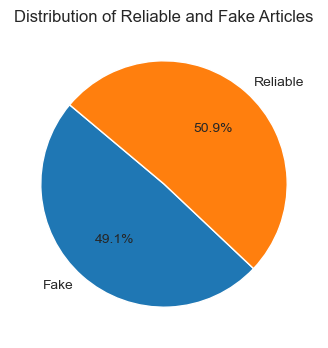

In [183]:
values, counts = np.unique(y, return_counts=True)

# Plotting
labels = ['Fake', 'Reliable'] 
plt.figure(figsize=(6, 4))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Reliable and Fake Articles')
plt.show()

## Simple Baseline Classifiers

### Random guessing

In [184]:
uniform_classifier = DummyClassifier(strategy='uniform', random_state=0)
uniform_classifier.fit(X_train, y_train)
uniform_y_pred = uniform_classifier.predict(X_val)

# Calculate metrics
uniform_accuracy = accuracy_score(y_val, uniform_y_pred)
uniform_f1 = f1_score(y_val, uniform_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Uniform Random classifier: {uniform_accuracy:.4f}")
print(f"F1 score of Uniform Random classifier: {uniform_f1:.4f}\n")

Accuracy of Uniform Random classifier: 0.4956
F1 score of Uniform Random classifier: 0.4957


### Guessing most frequent label

In [185]:
most_frequent_classifier = DummyClassifier(strategy='most_frequent', random_state=0)
most_frequent_classifier.fit(X_train, y_train)
most_frequent_y_pred = most_frequent_classifier.predict(X_val)

# Calculate metrics
most_frequent_accuracy = accuracy_score(y_val, most_frequent_y_pred)
most_frequent_f1 = f1_score(y_val, most_frequent_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Most Frequent classifier: {most_frequent_accuracy:.4f}")
print(f"F1 score of Most Frequent classifier: {most_frequent_f1:.4f}\n")

Accuracy of Most Frequent classifier: 0.5099
F1 score of Most Frequent classifier: 0.3444


### Single feature logistic regression

#### Feature Engineering

In [186]:
def engineer_content(article_content):
    """
    This function takes the content of a single article and returns some interesting number about it.
    Currently, the function returns the average length of the words in the article, but this should be changed.
    """
    if isinstance(article_content, str):
        words = article_content.split()  # Split the string into words
        if len(words) == 0:  # Handle the case of an empty string
            return 0
        return sum(len(word) for word in words) / len(words)  # Calculate average word length
    elif isinstance(article_content, (int, float)):
        if np.isnan(article_content):  # Check for NaN
            return 0  # Assuming 0 as the representation for NaN, adjust as needed
        return article_content
    # Add more conditions here for other types if necessary
    else:
        return 1  # Placeholder for types where 'length' doesn't apply directly
    
def engineer_meta_data(meta_data):
    """
    This function takes some meta-data of a single article and returns some interesting number about it.
    Currently, the function returns the average length of the words in the provided object, but this should be changed.
    """
    if isinstance(meta_data, str):
        words = meta_data.split()  # Split the string into words
        if len(words) == 0:  # Handle the case of an empty string
            return 0
        return sum(len(word) for word in words) / len(words)  # Calculate average word length
    elif isinstance(meta_data, (int, float)):
        if np.isnan(meta_data):  # Check for NaN
            return 0  # Assuming 0 as the representation for NaN, adjust as needed
        return meta_data
    # Add more conditions here for other types if necessary
    else:
        return 1  # Placeholder for types where 'length' doesn't apply directly

In [187]:
X_train_single_features = []
for row in X_train:
    X_train_single_features.append([engineer_content(row[4])])
    
X_val_single_features = []
for row in X_val:
    X_val_single_features.append([engineer_content(row[4])])

In [189]:
parameters = {
        'C': np.logspace(-4, 4, 5),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga', 'elasticnet'],
        'tol': [1e-4, 1e-3, 1e-2],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 1000, 5000],
    }

single_feature_logistic_regression_model = GridSearchCV(LogisticRegression(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
#single_feature_logistic_regression_model = LogisticRegression(solver="liblinear")
single_feature_logistic_regression_model.fit(X_train_single_features, y_train)

# Evaluate on validation set
single_feature_logistic_regression_y_pred = single_feature_logistic_regression_model.predict(X_val_single_features)

# Calculate metrics
single_feature_logistic_regression_accuracy = accuracy_score(y_val, single_feature_logistic_regression_y_pred)
single_feature_logistic_regression_f1 = f1_score(y_val, single_feature_logistic_regression_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Single Feature Logistic Regression classifier: {single_feature_logistic_regression_accuracy:.4f}")
print(f"F1 score of Single Feature Logistic Regression classifier: {single_feature_logistic_regression_f1:.4f}\n")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

Accuracy of Single Feature Logistic Regression classifier: 0.5310
F1 score of Single Feature Logistic Regression classifier: 0.4942


## Comparison of baseline models

In [190]:
def display_model_comparisons(model_names, accuracies, f1_scores):
    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plotting accuracy scores
    ax[0].bar(model_names, accuracies, color='skyblue')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    ax[0].set_xticks(range(len(model_names)))  # Set x-ticks positions
    ax[0].set_xticklabels(model_names, rotation=45, ha="right")  # Rotate labels to avoid overlap
    for i, v in enumerate(accuracies):
        ax[0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
    
    # Plotting F1 scores
    ax[1].bar(model_names, f1_scores, color='orange')
    ax[1].set_title('Model F1 Score')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_ylim(0, 1)  # Assuming F1 score values are between 0 and 1
    ax[1].set_xticks(range(len(model_names)))  # Set x-ticks positions
    ax[1].set_xticklabels(model_names, rotation=45, ha="right")  # Rotate labels to avoid overlap
    for i, v in enumerate(f1_scores):
        ax[1].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
    
    # Improve layout and show plot
    plt.tight_layout()
    plt.show()


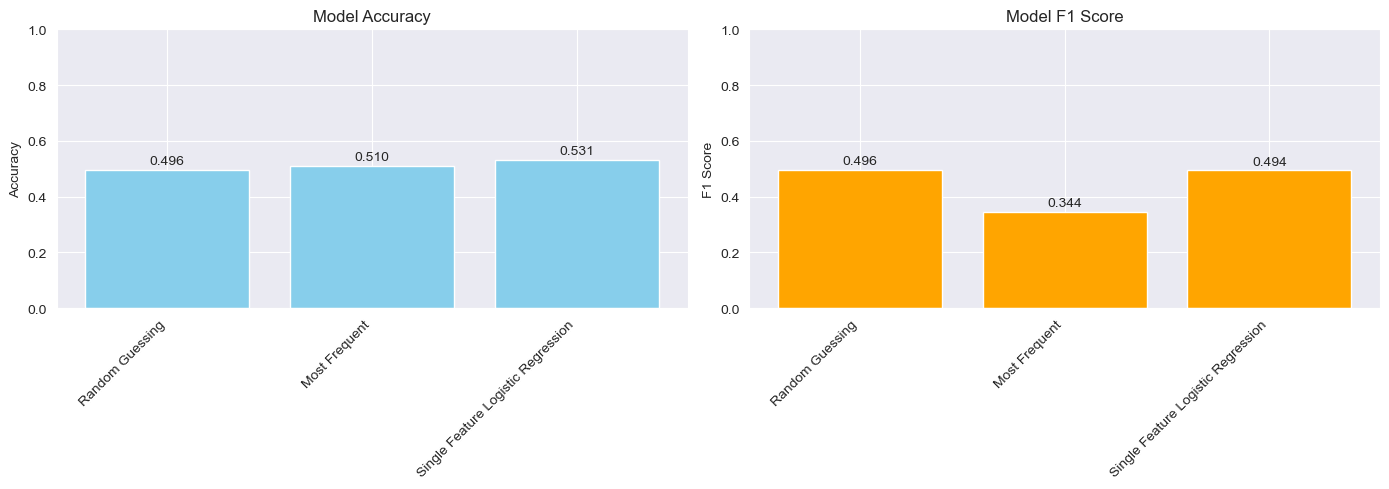

In [191]:
display_model_comparisons(
    ['Random Guessing', 'Most Frequent', 'Single Feature Logistic Regression'],
    [uniform_accuracy, most_frequent_accuracy, single_feature_logistic_regression_accuracy],
    [uniform_f1, most_frequent_f1, single_feature_logistic_regression_f1]
)

## Adding meta-data features

In [195]:
scaler = StandardScaler()

X_train_multiple_features = []
for row in X_train:
    X_train_multiple_features.append([engineer_content(row[4]), engineer_meta_data(row[8])])
    
X_val_multiple_features = []
for row in X_val:
    X_val_multiple_features.append([engineer_content(row[4]), engineer_meta_data(row[8])])
    
X_train_multiple_features = scaler.fit_transform(X_train_multiple_features)
X_val_multiple_features = scaler.fit_transform(X_val_multiple_features)


In [196]:
multiple_feature_logistic_regression_model = GridSearchCV(LogisticRegression(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
#multiple_feature_logistic_regression_model = LogisticRegression()
multiple_feature_logistic_regression_model.fit(X_train_multiple_features, y_train)

# Evaluate on validation set
multiple_feature_logistic_regression_y_pred = multiple_feature_logistic_regression_model.predict(X_val_multiple_features)

# Calculate metrics
multiple_feature_logistic_regression_accuracy = accuracy_score(y_val, multiple_feature_logistic_regression_y_pred)
multiple_feature_logistic_regression_f1 = f1_score(y_val, multiple_feature_logistic_regression_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Multiple Feature Logistic Regression classifier: {multiple_feature_logistic_regression_accuracy:.4f}")
print(f"F1 score of Multiple Feature Logistic Regression classifier: {multiple_feature_logistic_regression_f1:.4f}\n")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constrain

Accuracy of Multiple Feature Logistic Regression classifier: 0.5495
F1 score of Multiple Feature Logistic Regression classifier: 0.5326


### Comparing logistic regression models with and with-out added meta-data features

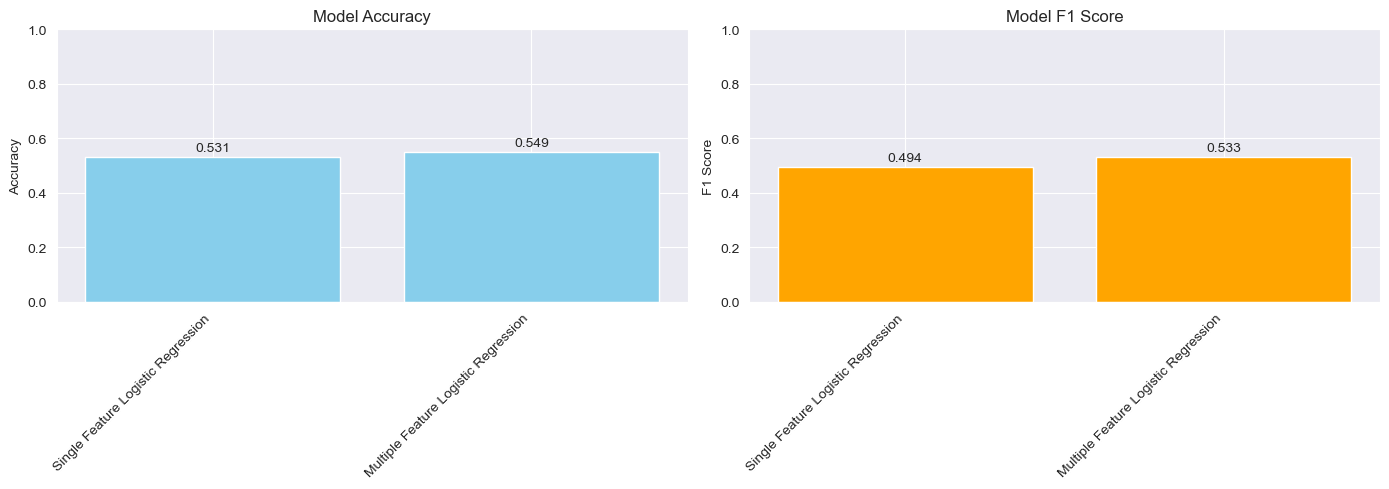

In [197]:
display_model_comparisons(
    ['Single Feature Logistic Regression', 'Multiple Feature Logistic Regression'],
    [single_feature_logistic_regression_accuracy, multiple_feature_logistic_regression_accuracy],
    [single_feature_logistic_regression_f1, multiple_feature_logistic_regression_f1]
)

### Adding extra reliable data

In [198]:
## CODE TO LOAD AND CLEAN SCRAPED ARTICLES AND SAVE TO NEW CSV

In [201]:
path = 'scraped_articles.csv'
df = pd.read_csv(path)

X = df.to_numpy()
y = np.ones(len(df))

y_train_combined = np.concatenate((y_train, y), axis=0)

X_train_extra_reliable_single_features = []
for row in X:
    X_train_extra_reliable_single_features.append([engineer_content(row[4])])
X_train_single_features_combined = np.concatenate((X_train_single_features, X_train_extra_reliable_single_features), axis=0)

X_train_extra_reliable_multiple_features = []
for row in X:
    X_train_extra_reliable_multiple_features.append([engineer_content(row[4]), engineer_meta_data(row[1])])
X_train_multiple_features_combined = np.concatenate((X_train_multiple_features, X_train_extra_reliable_multiple_features), axis=0)

X_train_extra_reliable_multiple_features = scaler.fit_transform(X_train_multiple_features_combined)

In [202]:
single_feature_logistic_regression_model.fit(X_train_single_features_combined, y_train_combined)

# Evaluate on validation set
single_feature_combined_logistic_regression_y_pred = single_feature_logistic_regression_model.predict(X_val_single_features)

# Calculate metrics
single_feature_combined_logistic_regression_accuracy = accuracy_score(y_val, single_feature_combined_logistic_regression_y_pred)
single_feature_combined_logistic_regression_f1 = f1_score(y_val, single_feature_combined_logistic_regression_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Single Feature Combined Logistic Regression classifier: {single_feature_combined_logistic_regression_accuracy:.4f}")
print(f"F1 score of Single Feature Combined Logistic Regression classifier: {single_feature_combined_logistic_regression_f1:.4f}\n")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

Accuracy of Single Feature Combined Logistic Regression classifier: 0.5338
F1 score of Single Feature Combined Logistic Regression classifier: 0.4890


In [203]:
multiple_feature_logistic_regression_model.fit(X_train_multiple_features_combined, y_train_combined)

# Evaluate on validation set
multiple_feature_combined_logistic_regression_y_pred = multiple_feature_logistic_regression_model.predict(X_val_multiple_features)

# Calculate metrics
multiple_feature_combined_logistic_regression_accuracy = accuracy_score(y_val, multiple_feature_combined_logistic_regression_y_pred)
multiple_feature_combined_logistic_regression_f1 = f1_score(y_val, multiple_feature_combined_logistic_regression_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of Multiple Feature Combined Logistic Regression classifier: {multiple_feature_combined_logistic_regression_accuracy:.4f}")
print(f"F1 score of Multiple Feature Combined Logistic Regression classifier: {multiple_feature_combined_logistic_regression_f1:.4f}\n")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constrain

Accuracy of Multiple Feature Combined Logistic Regression classifier: 0.5290
F1 score of Multiple Feature Combined Logistic Regression classifier: 0.4186


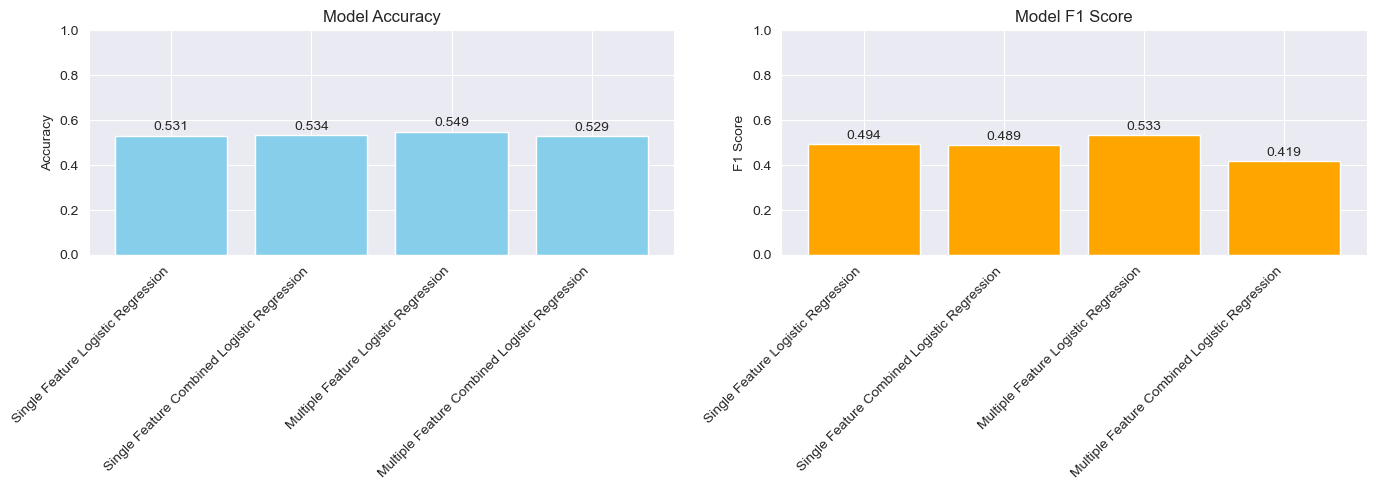

In [204]:
display_model_comparisons(
    ['Single Feature Logistic Regression', 'Single Feature Combined Logistic Regression', 'Multiple Feature Logistic Regression', 'Multiple Feature Combined Logistic Regression'],
    [single_feature_logistic_regression_accuracy, single_feature_combined_logistic_regression_accuracy, multiple_feature_logistic_regression_accuracy, multiple_feature_combined_logistic_regression_accuracy],
    [single_feature_logistic_regression_f1, single_feature_combined_logistic_regression_f1, multiple_feature_logistic_regression_f1, multiple_feature_combined_logistic_regression_f1]
)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset
# Assuming 'df' is your DataFrame with 'text' and 'label' columns
df = pd.read_csv('cleaned.csv')

# Preprocess your data
# This step is dataset specific and may include removing special characters, tokenization, etc.

unambiguous_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
df = df[df['type'].notna() & (df['type'].isin(unambiguous_types)) & df['content'].notna()]

reliable_types = ['reliable', 'political']

X = df['content'].to_numpy()
y = np.array([int(t in reliable_types) for t in df['type'] ])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
max_length = max([len(x) for x in sequences])

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Pad sequences
X_train_padded = pad_sequences(sequences, maxlen=max_length)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_75880/602624695.py:8: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned.csv')


Found 1177194 unique tokens.


In [227]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import Constant
import joblib

# Load pre-trained word embeddings
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define model
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False)
])
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_padded, y_train, batch_size=128, epochs=10, validation_data=(X_val_padded, y_val))

# Evaluate model
score, accuracy = model.evaluate(X_val_padded, y_val)
print(f'Validation score: {score}, accuracy: {accuracy}')

joblib.dump(model, 'neural_net.joblib')

KeyboardInterrupt: 

In [ ]:
#multiple_feature_logistic_regression_model = GridSearchCV(LogisticRegression(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
embedded_logistic_regression_model = LogisticRegression(solver='liblinear', C=1.0, penalty='l2')
embedded_logistic_regression_model.fit(X_train_padded, y_train)

# Evaluate on validation set
embedded_logistic_regression_y_pred = embedded_logistic_regression_model.predict(X_val_padded)

# Calculate metrics
embedded_logistic_regression_accuracy = accuracy_score(y_val, embedded_logistic_regression_y_pred)
embedded_logistic_regression_f1 = f1_score(y_val, embedded_logistic_regression_y_pred, average='weighted')

# Display the scores
print(f"Accuracy of embedded Logistic Regression classifier: {embedded_logistic_regression_accuracy:.4f}")
print(f"F1 score of embedded Logistic Regression classifier: {embedded_logistic_regression_f1:.4f}\n")

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import time

# Load pre-trained word embeddings
print('creating embedding index')
start_time = time.time()
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
        
elapsed_time = time.time() - start_time
print(f"finished creating embedding index in: {elapsed_time:.3f} seconds")

# Assuming embedding_index is your dictionary containing word: embedding pairs from GloVe
# Function to convert articles into averaged word embeddings
def text_to_avg_vector(text_series, tokenizer, embedding_index, embedding_dim=100):
    vectors = []
    for text in text_series:
        tokens = tokenizer.texts_to_sequences([text])[0]
        article_vectors = [embedding_index.get(tokenizer.index_word[token], np.zeros(embedding_dim)) for token in tokens]
        if article_vectors:
            vectors.append(np.mean(article_vectors, axis=0))
        else:
            vectors.append(np.zeros(embedding_dim))
    return np.array(vectors)

# Load your dataset
# Assuming 'df' is your DataFrame with 'text' and 'label' columns
print('reading cleaned articles')
start_time = time.time()
df = pd.read_csv('cleaned.csv')
elapsed_time = time.time() - start_time
print(f"finished reading articles in: {elapsed_time:.3f} seconds")

# Preprocess your data
# This step is dataset specific and may include removing special characters, tokenization, etc.
print('dropping bad articles')
start_time = time.time()
unambiguous_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
df = df[df['type'].notna() & (df['type'].isin(unambiguous_types)) & df['content'].notna()]
elapsed_time = time.time() - start_time
print(f"finished dropping articles in: {elapsed_time:.3f} seconds")

# Tokenize text
print('fitting tokenizer')
start_time = time.time()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'])
elapsed_time = time.time() - start_time
print(f"finished fitting tokenizer in: {elapsed_time:.3f} seconds")

# Convert each article to averaged word embeddings
print('converting content of articles to vectors')
start_time = time.time()
X = text_to_avg_vector(df['content'], tokenizer, embedding_index)
elapsed_time = time.time() - start_time
print(f"finished converting articles in: {elapsed_time:.3f} seconds")

# Your labels remain the same
print('converting types to binary labels')
start_time = time.time()
reliable_types = ['reliable', 'political']
y = np.array([int(t in reliable_types) for t in df['type']])
elapsed_time = time.time() - start_time
print(f"finished converting types in: {elapsed_time:.3f} seconds")

creating embedding index
finished creating embedding index in: 3.906 seconds
reading cleaned articles


/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_76281/1844717608.py:40: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned.csv')


finished reading articles in: 32.205 seconds
dropping bad articles
finished dropping articles in: 1.556 seconds
fitting tokenizer
finished fitting tokenizer in: 103.440 seconds
converting content of articles to vectors
finished converting articles in: 272.530 seconds
converting types to binary labels
finished converting types in: 0.103 seconds
splitting data
finished splitting data in: 0.390 seconds
fitting model
finished fitting model in: 16.462 seconds
make predictions on val set
finished making predictions in: 0.021 seconds
calculation metrics
finished calculating metrics in: 0.035 seconds
Accuracy of embedded Logistic Regression classifier: 0.7507
F1 score of embedded Logistic Regression classifier: 0.7504


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data
print('splitting data')
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27)
elapsed_time = time.time() - start_time
print(f"finished splitting data in: {elapsed_time:.3f} seconds")

# Initialize and train the logistic regression model
print('fitting model')
start_time = time.time()

# Define the model and the grid of hyperparameters to search
embedded_logistic_regression_model = LogisticRegression()
parameters = {
    'C': [0.01, 1, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 1000],
    'tol': [1e-4, 1e-3],
}

# Setup GridSearchCV
grid_search = GridSearchCV(embedded_logistic_regression_model, parameters, cv=3, scoring='accuracy', verbose=4, n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Once GridSearchCV finds the best hyperparameters, we refit the model on the combined training and validation sets for final evaluation on the test set
best_model = grid_search.best_estimator_

elapsed_time = time.time() - start_time
print(f"finished fitting model in: {elapsed_time:.3f} seconds")

# Evaluate on test set
print('make predictions on test set')
start_time = time.time()
embedded_logistic_regression_y_pred = best_model.predict(X_test)
elapsed_time = time.time() - start_time
print(f"finished making predictions in: {elapsed_time:.3f} seconds")

# Calculate metrics
print('calculation metrics')
start_time = time.time()
embedded_logistic_regression_accuracy = accuracy_score(y_test, embedded_logistic_regression_y_pred)
embedded_logistic_regression_f1 = f1_score(y_test, embedded_logistic_regression_y_pred, average='weighted')
elapsed_time = time.time() - start_time
print(f"finished calculating metrics in: {elapsed_time:.3f} seconds")

# Display the scores
print(f"Accuracy of embedded Logistic Regression classifier: {embedded_logistic_regression_accuracy:.4f}")
print(f"F1 score of embedded Logistic Regression classifier: {embedded_logistic_regression_f1:.4f}\n")

splitting data
finished splitting data in: 0.447 seconds
fitting model
Fitting 3 folds for each of 48 candidates, totalling 144 fits
